## K-Nearest Neighbors
* Usado para classificar objetos com base em exemplos de treinamento que estão mais próximos no espaço de características.
* Pré-requisitos:
  + Um conjunto de treinamento de exemplos;
  + Definir uma métrica (função) para calcular a distância entre as amostras de treinamento;
  + Definir o valor de K (o número de vizinhos mais próximos que serão considerados pelo algoritmo).
* Processo de Classificação:
  + Calcular a distância entre o exemplo desconhecido e o outros exemplos do conjunto de treinamento;
  + Identificar os K vizinhos mais próximos; 
  + Utilizar o rotulo da classe dos vizinhos mais próximos para determinar o rótulo de classe do exemplo desconhecido (votação majoritária);
* Vantagens:
  + Simples e de fácil implementação.
  + Em diversos casos apresenta ótimos resultados.
* Desvantagens:
  + A calibragem do parâmetro k pode levar tempo.
    - Se K for muito pequeno, a classificação fica sensível a pontos de ruído. 
    - Se k é muito grande, a vizinhança pode incluir elementos de outras classes.
  + Precisão perde acurácia se houverem ruído ou características irrelevantes.
  + Necessita de dados normalizados.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## 1) Importando os dados já tratados sem OneHotEncoding:

In [2]:
data = pd.read_csv("/Users/andrerodrigues/Google Drive/FIAP-MBA 8IA/006 - Modelos de IA e ML/Trabalho_Final_2/Exercicio8_v2/dados_clust_v2.csv", sep =",")
data = data.iloc[:,1:]
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,dbscan,kmeans,som
0,-122.23,452600.0,129,41,880,3,126,322,83.252,37.88,1,3,1
1,-122.22,358500.0,1106,21,7099,3,1138,2401,83.014,37.86,0,2,2
2,-122.24,352100.0,190,52,1467,3,177,496,72.574,37.85,1,3,1
3,-122.25,341300.0,235,52,1274,3,219,558,56.431,37.85,1,1,1
4,-122.25,342200.0,280,52,1627,3,259,565,38.462,37.85,1,1,1


## 2) Importando os dados já tratados com OneHotEncoding:

In [3]:
data_ohe = pd.read_csv("/Users/andrerodrigues/Google Drive/FIAP-MBA 8IA/006 - Modelos de IA e ML/Trabalho_Final_2/Exercicio8_v2/data_ohe_nostd_v2.csv", sep =",")
data_ohe = data_ohe.iloc[:,1:]
data_ohe["dbscan"] = data["dbscan"]
data_ohe["kmeans"] = data["kmeans"]
data_ohe["som"] = data["som"]
data_ohe.head()

,0,1,2,3,4,6,7,8,9,10,11,12,13,14,dbscan,kmeans,som
0,-122.23,452600.0,129.0,41.0,880.0,126.0,322.0,83.252,37.88,0.0,0.0,0.0,1.0,0.0,1,3,1
1,-122.22,358500.0,1106.0,21.0,7099.0,1138.0,2401.0,83.014,37.86,0.0,0.0,0.0,1.0,0.0,0,2,2
2,-122.24,352100.0,190.0,52.0,1467.0,177.0,496.0,72.574,37.85,0.0,0.0,0.0,1.0,0.0,1,3,1
3,-122.25,341300.0,235.0,52.0,1274.0,219.0,558.0,56.431,37.85,0.0,0.0,0.0,1.0,0.0,1,1,1
4,-122.25,342200.0,280.0,52.0,1627.0,259.0,565.0,38.462,37.85,0.0,0.0,0.0,1.0,0.0,1,1,1


#### a) Apenas como curiosidade, vejamos como as classes estão distribuidas em 'dbscan', 'kmeans' e 'som'

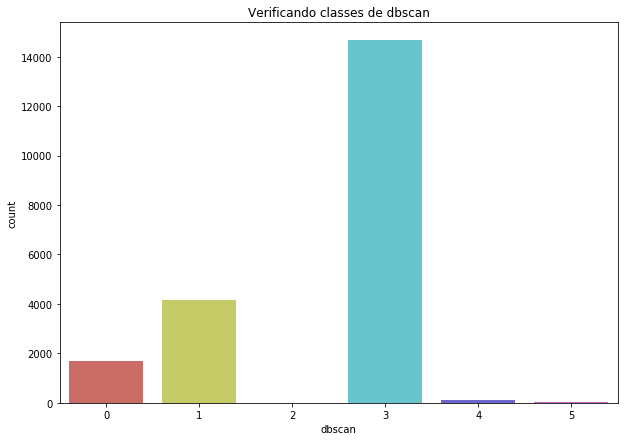

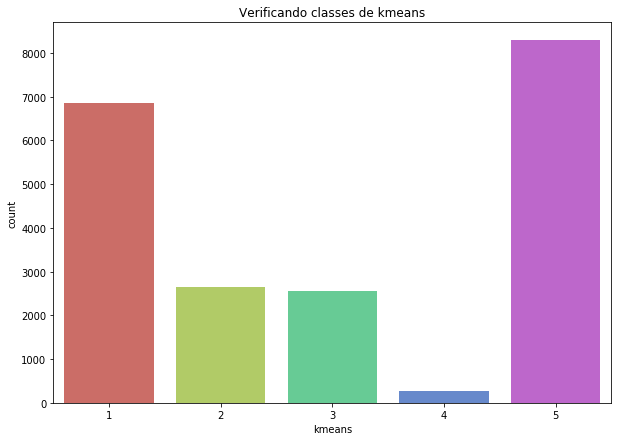

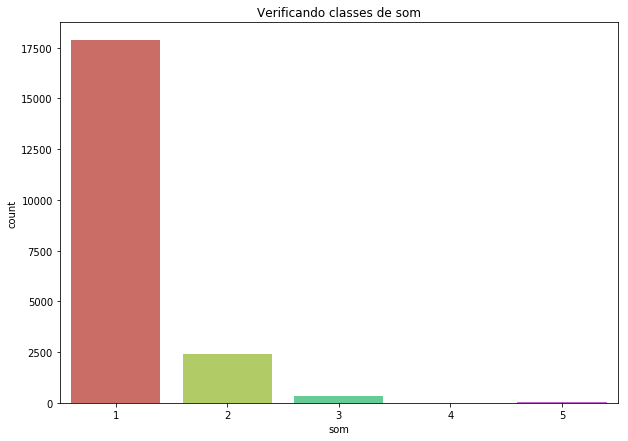

In [4]:
plt.figure(figsize=(10,7))
plot1 = sb.countplot(x='dbscan',data=data, palette='hls')
plt.title("Verificando classes de dbscan")
plt.show(plot1)
plt.figure(figsize=(10,7))
plot2 = sb.countplot(x='kmeans',data=data, palette='hls')
plt.title("Verificando classes de kmeans")
plt.show(plot2)
plt.figure(figsize=(10,7))
plot3 = sb.countplot(x='som',data=data, palette='hls')
plt.title("Verificando classes de som")
plt.show(plot3)

## 3) Seleciona o dataset para ser tratado pelo Modelo de Machine Learning e Separa as Classes

In [5]:
import traceback

def dataset_for_machine(dataset, target):
    
    # Tente receber o nome do arquivo
    try:
        d = dataset
        t = target
        
        
    
        if d == 'data':
            #No caso do DBSCAN, as amostras cujo o cluster for igual a 0, são consideradas outliers e não podemos considera-las como classe do problema.
            if t == 'dbscan':
                data.drop(data[data.dbscan == 0].index, inplace=True)
            # Troca o nome do dataset para df. A partir desse ponto, o dataset para ser tratado pelo modelo de ML será conhecido por df.
            df = data
            # Separa a classe
            classes = df[t]
            df.drop(columns=['dbscan','kmeans', 'som'], axis=1, inplace=True)


        elif d == 'data_ohe':
            #No caso do DBSCAN, as amostras cujo o cluster for igual a 0, são consideradas outliers e não podemos considera-las como classe do problema.
            if t == 'dbscan':
                data.drop(data[data.dbscan == 0].index, inplace=True)
            # Troca o nome do dataset para df. A partir desse ponto, o dataset para ser tratado pelo modelo de ML será conhecido por df.
            df = data_ohe
            # Separa a classe
            classes = df[t]
            df.drop(columns=['dbscan','kmeans', 'som'], axis=1, inplace=True)

        else:
            print("Escolha entre 'data' ou 'data_ohe'")
            exit

    # Se ocorrer um erro
    except:
        # Mostre na tela
        trace = traceback.format_exc()
        print ('Aconteceu um erro:\n', trace)
        # Encerre o programa
        raise SystemExit
        
    return df, classes
    
# df, classes = dataset_for_machine(input("Entre com o dataset que será tratado pela maquina('data' ou 'data_ohe') e o target('kmeans' ou 'som') separados por ',':"))
dataset = input("Entre com o dataset que será tratado pela maquina('data' ou 'data_ohe'):")
target = input("Entre com o target que será tratado pela maquina ('dbscan','kmeans' ou 'som'):")
df, classes = dataset_for_machine(dataset, target)

Entre com o dataset que será tratado pela maquina('data' ou 'data_ohe'): data
Entre com o target que será tratado pela maquina ('dbscan','kmeans' ou 'som'): dbscan


* A partir desse ponto, o dataset para ser tratado pelo modelo de ML será conhecido por df. A seleção se ele vai ser passado com ou sem One Hot Encoding foi feita acima.

In [6]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,-122.23,452600.0,129,41,880,3,126,322,83.252,37.88
2,-122.24,352100.0,190,52,1467,3,177,496,72.574,37.85
3,-122.25,341300.0,235,52,1274,3,219,558,56.431,37.85
4,-122.25,342200.0,280,52,1627,3,259,565,38.462,37.85
5,-122.25,269700.0,213,52,919,3,193,413,40.368,37.85


In [7]:
classes

0        1
2        1
3        1
4        1
5        1
        ..
20635    3
20636    3
20637    3
20638    3
20639    3
Name: dbscan, Length: 18959, dtype: int64

## 4) Classificacao KNN
#### a) Separar o conjunto em variavel resposta e variaveis de treinamento

In [8]:
X = df.iloc[:,0:].values
y = classes

print(X)
print(y)

[[-1.2223e+02  4.5260e+05  1.2900e+02 ...  3.2200e+02  8.3252e+01
   3.7880e+01]
 [-1.2224e+02  3.5210e+05  1.9000e+02 ...  4.9600e+02  7.2574e+01
   3.7850e+01]
 [-1.2225e+02  3.4130e+05  2.3500e+02 ...  5.5800e+02  5.6431e+01
   3.7850e+01]
 ...
 [-1.2122e+02  9.2300e+04  4.8500e+02 ...  1.0070e+03  1.7000e+00
   3.9430e+01]
 [-1.2132e+02  8.4700e+04  4.0900e+02 ...  7.4100e+02  1.8672e+01
   3.9430e+01]
 [-1.2124e+02  8.9400e+04  6.1600e+02 ...  1.3870e+03  2.3886e+01
   3.9370e+01]]
0        1
2        1
3        1
4        1
5        1
        ..
20635    3
20636    3
20637    3
20638    3
20639    3
Name: dbscan, Length: 18959, dtype: int64


#### b) Normalização dos dados

In [9]:
# Vamos guardar o valor não normalizado de X na variavel Xold
XNew = StandardScaler().fit_transform(X)
Xold = X
X = XNew

#### c) Agora dividir em treino e teste (teste com 30%)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)


Classif_KNN = KNeighborsClassifier(n_neighbors=5)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_test)

#### d) Avaliando o modelo
* analisando o rotulo real com o rotulo predito

In [11]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1270    0    0    0    0]
 [   0    4    0    0    0]
 [   0    0 4379    0    0]
 [   0    0    0   31    0]
 [   0    0    0    0    4]]


In [12]:
print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1270
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00      4379
           4       1.00      1.00      1.00        31
           5       1.00      1.00      1.00         4

    accuracy                           1.00      5688
   macro avg       1.00      1.00      1.00      5688
weighted avg       1.00      1.00      1.00      5688

1.0


#### e) Testando K=1 até K=26 

In [13]:
k_range = range(1, 26)

#### f) Lista todos as acurácias

In [14]:
scores = []

#### g) Faz um loop de 1 a 26 armazena no dicionário scores

In [15]:
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.999648382559775, 0.999648382559775, 0.9994725738396625, 0.9994725738396625, 0.9994725738396625, 0.9994725738396625, 0.9994725738396625, 0.9991209563994374, 0.9991209563994374, 0.9991209563994374, 0.9991209563994374, 0.9989451476793249, 0.9989451476793249, 0.9989451476793249, 0.9984177215189873, 0.9984177215189873, 0.9984177215189873, 0.9984177215189873, 0.9984177215189873, 0.9984177215189873]


#### h) Plota os valores de acc. em função do valor escolhido de K

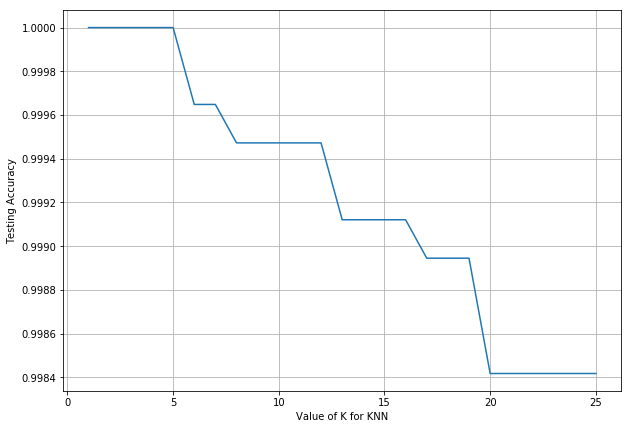

In [16]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca()

plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

plt.grid()
plt.show()

In [17]:
Classif_KNN = KNeighborsClassifier(n_neighbors=7)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_test)

In [18]:
cm = confusion_matrix(y_test, y_pred)

In [19]:
print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1270
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00      4379
           4       1.00      1.00      1.00        31
           5       1.00      0.75      0.86         4

    accuracy                           1.00      5688
   macro avg       1.00      0.90      0.94      5688
weighted avg       1.00      1.00      1.00      5688

0.999648382559775


* Usando data com apenas Label Encoding e usando DBSCAN, a maior acurácia é de 99.96% e acontece com uma vizinhanca igual a 2. 
* Usando data com apenas Label Encoding e usando K-means, a maior acurácia é de 96.65% e acontece com uma vizinhanca igual a 7.
* Usando data com apenas Label Encoding e usando SOM, a maior acurácia é de 98.74% e acontece com uma vizinhanca igual a 7.
* Usando data com One Hot Encoding e usando DBSCAN, a maior acurácia é de 97.25% e acontece com uma vizinhanca igual a 2.
* Usando data com One Hot Encoding e K-means, a maior acurácia é de 95.04% e acontece com uma vizinhanca igual a 5.
* Usando data com One Hot Encoding e SOM, a maior acurácia é de 98.59% e acontece com uma vizinhanca igual a 7.

#### Com base nos resultados, se fossemos usar o KNN como classificador, elegeríamos tratar os dados com Label Encoding usando como clusterizador o DBSCAN, pois essa combinação obteve a maior acurácia.